In [1]:
import numpy as np
import torch

from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]
    
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/


torch.Size([128, 3, 32, 32]) torch.Size([128])


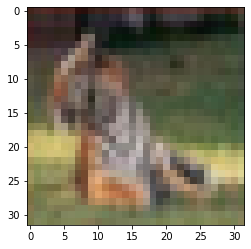

In [4]:
for img, label in valid_loader:
    print(img.shape, label.shape)
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [5]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 200)
        self.fc2 = torch.nn.Linear(200, 150)
        self.out = torch.nn.Linear(150, 100)
        
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net()
net.to(device)
print(net)

Net(
  (dp_three): Dropout(p=0.2, inplace=False)
  (dp_four): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=150, bias=True)
  (out): Linear(in_features=150, out_features=100, bias=True)
)


In [6]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [7]:
from time import time
from tqdm import tqdm


def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in tqdm(range(num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses

In [8]:
print_every = 50
num_epoch = 20

net, train_losses, val_losses = train(
    model=net,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_loader,
    test_dataloader=valid_loader,
    print_every=print_every,
    num_epoch=num_epoch
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1]/[20]. Batch [50]/[372]. Train loss 4.591. Train acc 2.281. Val loss 4.555. Val acc 3.040. Took 8.756 seconds
Epoch [1]/[20]. Batch [100]/[372]. Train loss 4.550. Train acc 2.812. Val loss 4.461. Val acc 3.880. Took 1.995 seconds
Epoch [1]/[20]. Batch [150]/[372]. Train loss 4.493. Train acc 3.583. Val loss 4.329. Val acc 5.800. Took 1.944 seconds
Epoch [1]/[20]. Batch [200]/[372]. Train loss 4.435. Train acc 4.102. Val loss 4.211. Val acc 7.440. Took 1.965 seconds
Epoch [1]/[20]. Batch [250]/[372]. Train loss 4.377. Train acc 4.834. Val loss 4.103. Val acc 8.640. Took 2.549 seconds
Epoch [1]/[20]. Batch [300]/[372]. Train loss 4.326. Train acc 5.339. Val loss 4.063. Val acc 8.640. Took 2.003 seconds
Epoch [1]/[20]. Batch [350]/[372]. Train loss 4.285. Train acc 5.795. Val loss 4.038. Val acc 9.360. Took 2.022 seconds


  5%|▌         | 1/20 [00:22<07:01, 22.18s/it]

Epoch took 22.175549030303955
Epoch [2]/[20]. Batch [28]/[372]. Train loss 0.299. Train acc 7.115. Val loss 4.169. Val acc 8.640. Took 1.666 seconds
Epoch [2]/[20]. Batch [78]/[372]. Train loss 0.720. Train acc 7.863. Val loss 4.054. Val acc 8.520. Took 1.984 seconds
Epoch [2]/[20]. Batch [128]/[372]. Train loss 1.049. Train acc 8.221. Val loss 4.003. Val acc 9.680. Took 2.422 seconds
Epoch [2]/[20]. Batch [178]/[372]. Train loss 1.313. Train acc 8.769. Val loss 3.973. Val acc 10.240. Took 2.144 seconds
Epoch [2]/[20]. Batch [228]/[372]. Train loss 1.528. Train acc 9.221. Val loss 3.886. Val acc 12.000. Took 1.977 seconds
Epoch [2]/[20]. Batch [278]/[372]. Train loss 1.711. Train acc 9.473. Val loss 3.896. Val acc 10.720. Took 1.983 seconds
Epoch [2]/[20]. Batch [328]/[372]. Train loss 1.865. Train acc 9.685. Val loss 3.874. Val acc 11.880. Took 1.961 seconds


 10%|█         | 2/20 [00:37<05:30, 18.34s/it]

Epoch took 15.64904522895813
Epoch [3]/[20]. Batch [6]/[372]. Train loss 0.033. Train acc 6.771. Val loss 3.875. Val acc 12.520. Took 0.418 seconds
Epoch [3]/[20]. Batch [56]/[372]. Train loss 0.273. Train acc 10.700. Val loss 3.862. Val acc 11.560. Took 2.525 seconds
Epoch [3]/[20]. Batch [106]/[372]. Train loss 0.482. Train acc 10.915. Val loss 3.840. Val acc 12.000. Took 2.198 seconds
Epoch [3]/[20]. Batch [156]/[372]. Train loss 0.667. Train acc 11.168. Val loss 3.806. Val acc 12.320. Took 2.902 seconds
Epoch [3]/[20]. Batch [206]/[372]. Train loss 0.831. Train acc 11.415. Val loss 3.782. Val acc 12.880. Took 1.958 seconds
Epoch [3]/[20]. Batch [256]/[372]. Train loss 0.976. Train acc 11.694. Val loss 3.818. Val acc 11.440. Took 2.011 seconds
Epoch [3]/[20]. Batch [306]/[372]. Train loss 1.109. Train acc 11.834. Val loss 3.755. Val acc 13.280. Took 2.282 seconds
Epoch [3]/[20]. Batch [356]/[372]. Train loss 1.230. Train acc 11.901. Val loss 3.727. Val acc 13.280. Took 2.226 seconds

 15%|█▌        | 3/20 [00:54<05:01, 17.76s/it]

Epoch took 17.06238603591919
Epoch [4]/[20]. Batch [34]/[372]. Train loss 0.120. Train acc 8.732. Val loss 3.856. Val acc 12.960. Took 1.398 seconds
Epoch [4]/[20]. Batch [84]/[372]. Train loss 0.275. Train acc 10.342. Val loss 3.787. Val acc 12.520. Took 1.964 seconds
Epoch [4]/[20]. Batch [134]/[372]. Train loss 0.415. Train acc 11.299. Val loss 3.762. Val acc 12.680. Took 2.049 seconds
Epoch [4]/[20]. Batch [184]/[372]. Train loss 0.543. Train acc 11.625. Val loss 3.741. Val acc 13.360. Took 1.993 seconds
Epoch [4]/[20]. Batch [234]/[372]. Train loss 0.661. Train acc 11.949. Val loss 3.757. Val acc 12.200. Took 2.769 seconds
Epoch [4]/[20]. Batch [284]/[372]. Train loss 0.770. Train acc 12.203. Val loss 3.728. Val acc 13.840. Took 2.442 seconds
Epoch [4]/[20]. Batch [334]/[372]. Train loss 0.870. Train acc 12.456. Val loss 3.720. Val acc 13.600. Took 1.944 seconds


 20%|██        | 4/20 [01:10<04:32, 17.02s/it]

Epoch took 15.865086078643799
Epoch [5]/[20]. Batch [12]/[372]. Train loss 0.032. Train acc 10.026. Val loss 3.747. Val acc 13.080. Took 0.635 seconds
Epoch [5]/[20]. Batch [62]/[372]. Train loss 0.152. Train acc 12.324. Val loss 3.725. Val acc 12.880. Took 1.952 seconds
Epoch [5]/[20]. Batch [112]/[372]. Train loss 0.263. Train acc 12.556. Val loss 3.702. Val acc 13.880. Took 1.952 seconds
Epoch [5]/[20]. Batch [162]/[372]. Train loss 0.366. Train acc 13.011. Val loss 3.706. Val acc 13.720. Took 2.276 seconds
Epoch [5]/[20]. Batch [212]/[372]. Train loss 0.463. Train acc 13.167. Val loss 3.673. Val acc 14.360. Took 2.236 seconds
Epoch [5]/[20]. Batch [262]/[372]. Train loss 0.554. Train acc 13.433. Val loss 3.650. Val acc 14.520. Took 1.956 seconds
Epoch [5]/[20]. Batch [312]/[372]. Train loss 0.640. Train acc 13.599. Val loss 3.655. Val acc 14.840. Took 1.971 seconds
Epoch [5]/[20]. Batch [362]/[372]. Train loss 0.721. Train acc 13.795. Val loss 3.664. Val acc 15.080. Took 1.986 seco

 25%|██▌       | 5/20 [01:26<04:05, 16.40s/it]

Epoch took 15.288689136505127
Epoch [6]/[20]. Batch [40]/[372]. Train loss 0.082. Train acc 10.137. Val loss 3.694. Val acc 14.320. Took 1.629 seconds
Epoch [6]/[20]. Batch [90]/[372]. Train loss 0.175. Train acc 12.266. Val loss 3.693. Val acc 13.280. Took 2.395 seconds
Epoch [6]/[20]. Batch [140]/[372]. Train loss 0.262. Train acc 12.840. Val loss 3.658. Val acc 14.880. Took 2.107 seconds
Epoch [6]/[20]. Batch [190]/[372]. Train loss 0.344. Train acc 13.277. Val loss 3.632. Val acc 14.760. Took 1.960 seconds
Epoch [6]/[20]. Batch [240]/[372]. Train loss 0.421. Train acc 13.773. Val loss 3.646. Val acc 14.640. Took 1.946 seconds
Epoch [6]/[20]. Batch [290]/[372]. Train loss 0.495. Train acc 14.033. Val loss 3.664. Val acc 14.440. Took 1.934 seconds
Epoch [6]/[20]. Batch [340]/[372]. Train loss 0.565. Train acc 14.189. Val loss 3.708. Val acc 13.880. Took 1.963 seconds


 30%|███       | 6/20 [01:41<03:44, 16.01s/it]

Epoch took 15.25615644454956
Epoch [7]/[20]. Batch [18]/[372]. Train loss 0.031. Train acc 10.417. Val loss 3.624. Val acc 15.040. Took 1.191 seconds
Epoch [7]/[20]. Batch [68]/[372]. Train loss 0.109. Train acc 13.729. Val loss 3.612. Val acc 14.960. Took 2.448 seconds
Epoch [7]/[20]. Batch [118]/[372]. Train loss 0.184. Train acc 14.420. Val loss 3.630. Val acc 14.920. Took 2.202 seconds
Epoch [7]/[20]. Batch [168]/[372]. Train loss 0.255. Train acc 14.709. Val loss 3.646. Val acc 14.720. Took 2.004 seconds
Epoch [7]/[20]. Batch [218]/[372]. Train loss 0.322. Train acc 15.034. Val loss 3.631. Val acc 15.200. Took 2.032 seconds
Epoch [7]/[20]. Batch [268]/[372]. Train loss 0.386. Train acc 15.296. Val loss 3.618. Val acc 14.880. Took 2.158 seconds
Epoch [7]/[20]. Batch [318]/[372]. Train loss 0.448. Train acc 15.374. Val loss 3.588. Val acc 15.600. Took 2.411 seconds
Epoch [7]/[20]. Batch [368]/[372]. Train loss 0.507. Train acc 15.650. Val loss 3.609. Val acc 15.520. Took 1.976 secon

 35%|███▌      | 7/20 [01:57<03:30, 16.19s/it]

Epoch took 16.54751467704773
Epoch [8]/[20]. Batch [46]/[372]. Train loss 0.065. Train acc 13.315. Val loss 3.620. Val acc 15.640. Took 1.828 seconds
Epoch [8]/[20]. Batch [96]/[372]. Train loss 0.130. Train acc 14.445. Val loss 3.599. Val acc 14.960. Took 1.956 seconds
Epoch [8]/[20]. Batch [146]/[372]. Train loss 0.192. Train acc 15.015. Val loss 3.659. Val acc 14.480. Took 1.981 seconds
Epoch [8]/[20]. Batch [196]/[372]. Train loss 0.252. Train acc 15.322. Val loss 3.616. Val acc 15.320. Took 2.267 seconds
Epoch [8]/[20]. Batch [246]/[372]. Train loss 0.309. Train acc 15.638. Val loss 3.588. Val acc 15.120. Took 2.318 seconds
Epoch [8]/[20]. Batch [296]/[372]. Train loss 0.364. Train acc 15.712. Val loss 3.608. Val acc 15.680. Took 1.943 seconds
Epoch [8]/[20]. Batch [346]/[372]. Train loss 0.417. Train acc 15.862. Val loss 3.623. Val acc 15.720. Took 1.941 seconds


 40%|████      | 8/20 [02:13<03:10, 15.85s/it]

Epoch took 15.126419305801392
Epoch [9]/[20]. Batch [24]/[372]. Train loss 0.030. Train acc 13.184. Val loss 3.577. Val acc 16.000. Took 1.043 seconds
Epoch [9]/[20]. Batch [74]/[372]. Train loss 0.087. Train acc 15.815. Val loss 3.576. Val acc 15.640. Took 1.985 seconds
Epoch [9]/[20]. Batch [124]/[372]. Train loss 0.142. Train acc 16.236. Val loss 3.575. Val acc 15.960. Took 2.322 seconds
Epoch [9]/[20]. Batch [174]/[372]. Train loss 0.196. Train acc 16.343. Val loss 3.621. Val acc 15.400. Took 2.203 seconds
Epoch [9]/[20]. Batch [224]/[372]. Train loss 0.247. Train acc 16.619. Val loss 3.609. Val acc 15.720. Took 1.954 seconds
Epoch [9]/[20]. Batch [274]/[372]. Train loss 0.296. Train acc 16.845. Val loss 3.628. Val acc 15.400. Took 2.000 seconds
Epoch [9]/[20]. Batch [324]/[372]. Train loss 0.344. Train acc 16.942. Val loss 3.639. Val acc 15.400. Took 2.613 seconds


 45%|████▌     | 9/20 [02:28<02:54, 15.84s/it]

Epoch took 15.804916143417358
Epoch [10]/[20]. Batch [2]/[372]. Train loss 0.002. Train acc 17.969. Val loss 3.592. Val acc 15.480. Took 0.272 seconds
Epoch [10]/[20]. Batch [52]/[372]. Train loss 0.053. Train acc 17.458. Val loss 3.583. Val acc 15.480. Took 2.541 seconds
Epoch [10]/[20]. Batch [102]/[372]. Train loss 0.102. Train acc 17.509. Val loss 3.633. Val acc 15.480. Took 1.962 seconds
Epoch [10]/[20]. Batch [152]/[372]. Train loss 0.150. Train acc 17.676. Val loss 3.555. Val acc 16.120. Took 1.946 seconds
Epoch [10]/[20]. Batch [202]/[372]. Train loss 0.196. Train acc 17.772. Val loss 3.555. Val acc 16.800. Took 1.951 seconds
Epoch [10]/[20]. Batch [252]/[372]. Train loss 0.241. Train acc 17.773. Val loss 3.584. Val acc 16.280. Took 1.934 seconds
Epoch [10]/[20]. Batch [302]/[372]. Train loss 0.285. Train acc 17.943. Val loss 3.566. Val acc 16.200. Took 2.069 seconds
Epoch [10]/[20]. Batch [352]/[372]. Train loss 0.327. Train acc 17.933. Val loss 3.569. Val acc 15.800. Took 2.4

 50%|█████     | 10/20 [02:44<02:38, 15.83s/it]

Epoch took 15.802482843399048
Epoch [11]/[20]. Batch [30]/[372]. Train loss 0.029. Train acc 14.271. Val loss 3.552. Val acc 15.920. Took 1.264 seconds
Epoch [11]/[20]. Batch [80]/[372]. Train loss 0.075. Train acc 16.475. Val loss 3.527. Val acc 16.520. Took 1.962 seconds
Epoch [11]/[20]. Batch [130]/[372]. Train loss 0.118. Train acc 17.440. Val loss 3.556. Val acc 16.400. Took 1.986 seconds
Epoch [11]/[20]. Batch [180]/[372]. Train loss 0.160. Train acc 17.717. Val loss 3.569. Val acc 16.440. Took 1.935 seconds
Epoch [11]/[20]. Batch [230]/[372]. Train loss 0.201. Train acc 17.741. Val loss 3.549. Val acc 17.040. Took 2.129 seconds
Epoch [11]/[20]. Batch [280]/[372]. Train loss 0.241. Train acc 17.963. Val loss 3.589. Val acc 15.720. Took 2.371 seconds
Epoch [11]/[20]. Batch [330]/[372]. Train loss 0.280. Train acc 18.054. Val loss 3.550. Val acc 16.760. Took 1.968 seconds


 55%|█████▌    | 11/20 [02:59<02:20, 15.61s/it]

Epoch took 15.091872215270996
Epoch [12]/[20]. Batch [8]/[372]. Train loss 0.007. Train acc 14.648. Val loss 3.553. Val acc 16.520. Took 0.485 seconds
Epoch [12]/[20]. Batch [58]/[372]. Train loss 0.048. Train acc 17.538. Val loss 3.582. Val acc 15.520. Took 2.002 seconds
Epoch [12]/[20]. Batch [108]/[372]. Train loss 0.088. Train acc 17.882. Val loss 3.551. Val acc 16.080. Took 1.980 seconds
Epoch [12]/[20]. Batch [158]/[372]. Train loss 0.127. Train acc 18.023. Val loss 3.572. Val acc 15.880. Took 2.387 seconds
Epoch [12]/[20]. Batch [208]/[372]. Train loss 0.165. Train acc 18.247. Val loss 3.591. Val acc 16.160. Took 2.935 seconds
Epoch [12]/[20]. Batch [258]/[372]. Train loss 0.202. Train acc 18.447. Val loss 3.584. Val acc 16.080. Took 1.972 seconds
Epoch [12]/[20]. Batch [308]/[372]. Train loss 0.237. Train acc 18.737. Val loss 3.557. Val acc 16.480. Took 1.965 seconds
Epoch [12]/[20]. Batch [358]/[372]. Train loss 0.273. Train acc 18.759. Val loss 3.582. Val acc 16.200. Took 1.9

 60%|██████    | 12/20 [03:15<02:06, 15.79s/it]

Epoch took 16.188501358032227
Epoch [13]/[20]. Batch [36]/[372]. Train loss 0.029. Train acc 15.408. Val loss 3.528. Val acc 16.520. Took 1.474 seconds
Epoch [13]/[20]. Batch [86]/[372]. Train loss 0.066. Train acc 17.287. Val loss 3.547. Val acc 15.800. Took 2.291 seconds
Epoch [13]/[20]. Batch [136]/[372]. Train loss 0.102. Train acc 18.216. Val loss 3.544. Val acc 16.480. Took 2.293 seconds
Epoch [13]/[20]. Batch [186]/[372]. Train loss 0.137. Train acc 18.679. Val loss 3.560. Val acc 16.320. Took 1.985 seconds
Epoch [13]/[20]. Batch [236]/[372]. Train loss 0.171. Train acc 18.869. Val loss 3.516. Val acc 17.560. Took 1.985 seconds
Epoch [13]/[20]. Batch [286]/[372]. Train loss 0.204. Train acc 18.982. Val loss 3.595. Val acc 16.040. Took 1.992 seconds
Epoch [13]/[20]. Batch [336]/[372]. Train loss 0.237. Train acc 19.055. Val loss 3.565. Val acc 16.560. Took 1.996 seconds


 65%|██████▌   | 13/20 [03:31<01:49, 15.68s/it]

Epoch took 15.439391613006592
Epoch [14]/[20]. Batch [14]/[372]. Train loss 0.010. Train acc 16.629. Val loss 3.529. Val acc 16.160. Took 0.963 seconds
Epoch [14]/[20]. Batch [64]/[372]. Train loss 0.044. Train acc 19.177. Val loss 3.549. Val acc 16.320. Took 2.128 seconds
Epoch [14]/[20]. Batch [114]/[372]. Train loss 0.078. Train acc 19.387. Val loss 3.550. Val acc 17.480. Took 1.960 seconds
Epoch [14]/[20]. Batch [164]/[372]. Train loss 0.110. Train acc 19.369. Val loss 3.571. Val acc 16.160. Took 1.939 seconds
Epoch [14]/[20]. Batch [214]/[372]. Train loss 0.142. Train acc 19.356. Val loss 3.578. Val acc 16.160. Took 1.966 seconds
Epoch [14]/[20]. Batch [264]/[372]. Train loss 0.173. Train acc 19.540. Val loss 3.584. Val acc 16.080. Took 1.953 seconds
Epoch [14]/[20]. Batch [314]/[372]. Train loss 0.204. Train acc 19.638. Val loss 3.542. Val acc 16.960. Took 2.522 seconds
Epoch [14]/[20]. Batch [364]/[372]. Train loss 0.234. Train acc 19.686. Val loss 3.567. Val acc 16.600. Took 2.

 70%|███████   | 14/20 [03:47<01:34, 15.76s/it]

Epoch took 15.938692808151245
Epoch [15]/[20]. Batch [42]/[372]. Train loss 0.028. Train acc 16.239. Val loss 3.522. Val acc 17.000. Took 2.101 seconds
Epoch [15]/[20]. Batch [92]/[372]. Train loss 0.059. Train acc 18.351. Val loss 3.507. Val acc 17.480. Took 1.999 seconds
Epoch [15]/[20]. Batch [142]/[372]. Train loss 0.090. Train acc 19.157. Val loss 3.494. Val acc 17.480. Took 1.944 seconds
Epoch [15]/[20]. Batch [192]/[372]. Train loss 0.120. Train acc 19.401. Val loss 3.539. Val acc 17.240. Took 2.140 seconds
Epoch [15]/[20]. Batch [242]/[372]. Train loss 0.149. Train acc 19.673. Val loss 3.521. Val acc 17.880. Took 2.357 seconds
Epoch [15]/[20]. Batch [292]/[372]. Train loss 0.178. Train acc 19.847. Val loss 3.570. Val acc 16.800. Took 1.964 seconds
Epoch [15]/[20]. Batch [342]/[372]. Train loss 0.206. Train acc 20.038. Val loss 3.543. Val acc 17.360. Took 1.957 seconds


 75%|███████▌  | 15/20 [04:02<01:18, 15.69s/it]

Epoch took 15.496427297592163
Epoch [16]/[20]. Batch [20]/[372]. Train loss 0.013. Train acc 16.680. Val loss 3.490. Val acc 16.800. Took 0.916 seconds
Epoch [16]/[20]. Batch [70]/[372]. Train loss 0.042. Train acc 19.621. Val loss 3.490. Val acc 17.720. Took 1.945 seconds
Epoch [16]/[20]. Batch [120]/[372]. Train loss 0.070. Train acc 20.117. Val loss 3.531. Val acc 16.680. Took 2.252 seconds
Epoch [16]/[20]. Batch [170]/[372]. Train loss 0.098. Train acc 20.211. Val loss 3.544. Val acc 16.880. Took 2.256 seconds
Epoch [16]/[20]. Batch [220]/[372]. Train loss 0.126. Train acc 20.281. Val loss 3.525. Val acc 17.400. Took 1.990 seconds
Epoch [16]/[20]. Batch [270]/[372]. Train loss 0.153. Train acc 20.223. Val loss 3.504. Val acc 17.840. Took 1.984 seconds
Epoch [16]/[20]. Batch [320]/[372]. Train loss 0.179. Train acc 20.410. Val loss 3.550. Val acc 17.280. Took 1.976 seconds
Epoch [16]/[20]. Batch [370]/[372]. Train loss 0.205. Train acc 20.507. Val loss 3.614. Val acc 15.720. Took 1.

 80%|████████  | 16/20 [04:18<01:02, 15.58s/it]

Epoch took 15.339528799057007
Epoch [17]/[20]. Batch [48]/[372]. Train loss 0.028. Train acc 17.301. Val loss 3.517. Val acc 16.200. Took 2.348 seconds
Epoch [17]/[20]. Batch [98]/[372]. Train loss 0.055. Train acc 19.109. Val loss 3.544. Val acc 17.040. Took 2.166 seconds
Epoch [17]/[20]. Batch [148]/[372]. Train loss 0.081. Train acc 20.212. Val loss 3.572. Val acc 16.120. Took 1.975 seconds
Epoch [17]/[20]. Batch [198]/[372]. Train loss 0.107. Train acc 20.249. Val loss 3.523. Val acc 17.280. Took 2.009 seconds
Epoch [17]/[20]. Batch [248]/[372]. Train loss 0.132. Train acc 20.637. Val loss 3.508. Val acc 17.080. Took 2.386 seconds
Epoch [17]/[20]. Batch [298]/[372]. Train loss 0.157. Train acc 20.727. Val loss 3.501. Val acc 17.960. Took 2.361 seconds
Epoch [17]/[20]. Batch [348]/[372]. Train loss 0.182. Train acc 20.735. Val loss 3.538. Val acc 17.400. Took 2.600 seconds


 85%|████████▌ | 17/20 [04:34<00:47, 15.92s/it]

Epoch took 16.693923234939575
Epoch [18]/[20]. Batch [26]/[372]. Train loss 0.014. Train acc 17.007. Val loss 3.502. Val acc 17.600. Took 1.155 seconds
Epoch [18]/[20]. Batch [76]/[372]. Train loss 0.040. Train acc 19.377. Val loss 3.479. Val acc 17.120. Took 1.973 seconds
Epoch [18]/[20]. Batch [126]/[372]. Train loss 0.065. Train acc 20.468. Val loss 3.529. Val acc 17.320. Took 1.979 seconds
Epoch [18]/[20]. Batch [176]/[372]. Train loss 0.089. Train acc 20.619. Val loss 3.518. Val acc 17.520. Took 2.005 seconds
Epoch [18]/[20]. Batch [226]/[372]. Train loss 0.113. Train acc 20.658. Val loss 3.535. Val acc 17.040. Took 2.228 seconds
Epoch [18]/[20]. Batch [276]/[372]. Train loss 0.137. Train acc 20.927. Val loss 3.553. Val acc 16.560. Took 2.327 seconds
Epoch [18]/[20]. Batch [326]/[372]. Train loss 0.160. Train acc 20.957. Val loss 3.561. Val acc 16.720. Took 1.952 seconds


 90%|█████████ | 18/20 [04:50<00:31, 15.71s/it]

Epoch took 15.225423097610474
Epoch [19]/[20]. Batch [4]/[372]. Train loss 0.002. Train acc 21.289. Val loss 3.538. Val acc 17.520. Took 0.345 seconds
Epoch [19]/[20]. Batch [54]/[372]. Train loss 0.026. Train acc 21.528. Val loss 3.529. Val acc 17.120. Took 1.980 seconds
Epoch [19]/[20]. Batch [104]/[372]. Train loss 0.050. Train acc 22.025. Val loss 3.577. Val acc 17.080. Took 1.992 seconds
Epoch [19]/[20]. Batch [154]/[372]. Train loss 0.073. Train acc 21.946. Val loss 3.507. Val acc 17.960. Took 2.361 seconds
Epoch [19]/[20]. Batch [204]/[372]. Train loss 0.095. Train acc 21.955. Val loss 3.488. Val acc 18.120. Took 2.179 seconds
Epoch [19]/[20]. Batch [254]/[372]. Train loss 0.118. Train acc 21.792. Val loss 3.539. Val acc 17.920. Took 1.984 seconds
Epoch [19]/[20]. Batch [304]/[372]. Train loss 0.140. Train acc 21.795. Val loss 3.531. Val acc 17.360. Took 1.936 seconds
Epoch [19]/[20]. Batch [354]/[372]. Train loss 0.162. Train acc 21.965. Val loss 3.538. Val acc 17.520. Took 1.9

 95%|█████████▌| 19/20 [05:05<00:15, 15.62s/it]

Epoch took 15.383888483047485
Epoch [20]/[20]. Batch [32]/[372]. Train loss 0.015. Train acc 17.603. Val loss 3.508. Val acc 17.200. Took 1.366 seconds
Epoch [20]/[20]. Batch [82]/[372]. Train loss 0.038. Train acc 19.874. Val loss 3.511. Val acc 17.560. Took 2.586 seconds
Epoch [20]/[20]. Batch [132]/[372]. Train loss 0.060. Train acc 21.094. Val loss 3.510. Val acc 17.960. Took 2.661 seconds
Epoch [20]/[20]. Batch [182]/[372]. Train loss 0.081. Train acc 21.587. Val loss 3.565. Val acc 17.080. Took 1.951 seconds
Epoch [20]/[20]. Batch [232]/[372]. Train loss 0.103. Train acc 21.703. Val loss 3.510. Val acc 17.800. Took 1.999 seconds
Epoch [20]/[20]. Batch [282]/[372]. Train loss 0.124. Train acc 21.792. Val loss 3.534. Val acc 17.240. Took 1.993 seconds
Epoch [20]/[20]. Batch [332]/[372]. Train loss 0.145. Train acc 21.830. Val loss 3.517. Val acc 17.240. Took 1.974 seconds


100%|██████████| 20/20 [05:21<00:00, 16.10s/it]

Epoch took 16.423227310180664


In [9]:
from torchvision import models

In [10]:
resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [12]:
set_parameter_requires_grad(resnet50, True)

In [13]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
resnet50.fc = nn.Linear(2048, 100)

In [15]:
trans_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False)

torch.Size([128, 3, 224, 224]) torch.Size([128])


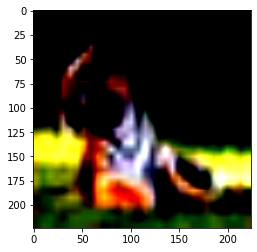

In [16]:
for img, label in valid_loader:
    print(img.shape, label.shape)
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [17]:

params_to_update = []
for name,param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [18]:
print_every = 50
num_epoch = 20

resnet50, train_losses, val_losses = train(
    model=resnet50,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_loader,
    test_dataloader=valid_loader,
    print_every=print_every,
    num_epoch=num_epoch
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1]/[20]. Batch [50]/[372]. Train loss 4.520. Train acc 3.375. Val loss 4.377. Val acc 7.920. Took 45.796 seconds
Epoch [1]/[20]. Batch [100]/[372]. Train loss 4.399. Train acc 7.719. Val loss 4.147. Val acc 16.840. Took 44.241 seconds
Epoch [1]/[20]. Batch [150]/[372]. Train loss 4.284. Train acc 12.245. Val loss 3.931. Val acc 24.960. Took 44.695 seconds
Epoch [1]/[20]. Batch [200]/[372]. Train loss 4.177. Train acc 16.230. Val loss 3.735. Val acc 31.800. Took 44.424 seconds
Epoch [1]/[20]. Batch [250]/[372]. Train loss 4.075. Train acc 19.441. Val loss 3.558. Val acc 35.520. Took 44.687 seconds
Epoch [1]/[20]. Batch [300]/[372]. Train loss 3.982. Train acc 22.112. Val loss 3.396. Val acc 37.320. Took 44.604 seconds
Epoch [1]/[20]. Batch [350]/[372]. Train loss 3.891. Train acc 24.612. Val loss 3.259. Val acc 40.560. Took 44.302 seconds
Epoch took 326.5346894264221


  5%|▌         | 1/20 [05:26<1:43:29, 326.81s/it]

Epoch [2]/[20]. Batch [28]/[372]. Train loss 0.224. Train acc 39.397. Val loss 3.130. Val acc 42.080. Took 30.941 seconds
Epoch [2]/[20]. Batch [78]/[372]. Train loss 0.546. Train acc 40.825. Val loss 3.022. Val acc 43.160. Took 44.360 seconds
Epoch [2]/[20]. Batch [128]/[372]. Train loss 0.789. Train acc 42.139. Val loss 2.913. Val acc 43.960. Took 44.456 seconds
Epoch [2]/[20]. Batch [178]/[372]. Train loss 0.981. Train acc 42.929. Val loss 2.819. Val acc 45.520. Took 44.446 seconds
Epoch [2]/[20]. Batch [228]/[372]. Train loss 1.134. Train acc 43.651. Val loss 2.734. Val acc 45.640. Took 44.545 seconds
Epoch [2]/[20]. Batch [278]/[372]. Train loss 1.257. Train acc 44.267. Val loss 2.660. Val acc 47.080. Took 44.417 seconds
Epoch [2]/[20]. Batch [328]/[372]. Train loss 1.357. Train acc 44.767. Val loss 2.587. Val acc 47.120. Took 44.601 seconds


 10%|█         | 2/20 [10:52<1:37:54, 326.37s/it]

Epoch took 325.89304399490356
Epoch [3]/[20]. Batch [6]/[372]. Train loss 0.021. Train acc 44.922. Val loss 2.536. Val acc 47.280. Took 16.084 seconds
Epoch [3]/[20]. Batch [56]/[372]. Train loss 0.179. Train acc 47.754. Val loss 2.473. Val acc 47.440. Took 44.366 seconds
Epoch [3]/[20]. Batch [106]/[372]. Train loss 0.313. Train acc 48.209. Val loss 2.420. Val acc 49.720. Took 44.616 seconds
Epoch [3]/[20]. Batch [156]/[372]. Train loss 0.431. Train acc 48.683. Val loss 2.364. Val acc 49.360. Took 44.728 seconds
Epoch [3]/[20]. Batch [206]/[372]. Train loss 0.533. Train acc 49.154. Val loss 2.329. Val acc 48.720. Took 44.420 seconds
Epoch [3]/[20]. Batch [256]/[372]. Train loss 0.623. Train acc 49.521. Val loss 2.292. Val acc 49.720. Took 44.829 seconds
Epoch [3]/[20]. Batch [306]/[372]. Train loss 0.703. Train acc 49.666. Val loss 2.240. Val acc 50.720. Took 44.699 seconds
Epoch [3]/[20]. Batch [356]/[372]. Train loss 0.774. Train acc 49.895. Val loss 2.218. Val acc 51.000. Took 44.3

 15%|█▌        | 3/20 [16:30<1:33:58, 331.68s/it]

Epoch took 337.8493025302887
Epoch [4]/[20]. Batch [34]/[372]. Train loss 0.065. Train acc 51.631. Val loss 2.182. Val acc 50.360. Took 34.746 seconds
Epoch [4]/[20]. Batch [84]/[372]. Train loss 0.154. Train acc 51.488. Val loss 2.152. Val acc 50.760. Took 44.310 seconds
Epoch [4]/[20]. Batch [134]/[372]. Train loss 0.235. Train acc 51.860. Val loss 2.126. Val acc 51.160. Took 44.064 seconds
Epoch [4]/[20]. Batch [184]/[372]. Train loss 0.306. Train acc 52.233. Val loss 2.097. Val acc 51.000. Took 44.677 seconds
Epoch [4]/[20]. Batch [234]/[372]. Train loss 0.373. Train acc 52.277. Val loss 2.075. Val acc 51.800. Took 44.377 seconds
Epoch [4]/[20]. Batch [284]/[372]. Train loss 0.434. Train acc 52.432. Val loss 2.059. Val acc 51.560. Took 44.331 seconds
Epoch [4]/[20]. Batch [334]/[372]. Train loss 0.491. Train acc 52.283. Val loss 2.021. Val acc 52.120. Took 44.326 seconds


 20%|██        | 4/20 [21:55<1:27:44, 329.01s/it]

Epoch took 324.71556663513184
Epoch [5]/[20]. Batch [12]/[372]. Train loss 0.016. Train acc 53.841. Val loss 2.002. Val acc 52.400. Took 20.424 seconds
Epoch [5]/[20]. Batch [62]/[372]. Train loss 0.080. Train acc 53.692. Val loss 1.990. Val acc 52.040. Took 44.331 seconds
Epoch [5]/[20]. Batch [112]/[372]. Train loss 0.140. Train acc 53.641. Val loss 1.969. Val acc 52.880. Took 44.328 seconds
Epoch [5]/[20]. Batch [162]/[372]. Train loss 0.194. Train acc 54.022. Val loss 1.956. Val acc 52.360. Took 44.438 seconds
Epoch [5]/[20]. Batch [212]/[372]. Train loss 0.246. Train acc 54.046. Val loss 1.934. Val acc 53.000. Took 44.536 seconds
Epoch [5]/[20]. Batch [262]/[372]. Train loss 0.295. Train acc 53.990. Val loss 1.916. Val acc 52.760. Took 44.298 seconds
Epoch [5]/[20]. Batch [312]/[372]. Train loss 0.340. Train acc 54.001. Val loss 1.898. Val acc 53.320. Took 44.516 seconds
Epoch [5]/[20]. Batch [362]/[372]. Train loss 0.383. Train acc 53.945. Val loss 1.893. Val acc 53.160. Took 44.

 25%|██▌       | 5/20 [27:32<1:22:59, 331.95s/it]

Epoch took 336.98364663124084
Epoch [6]/[20]. Batch [40]/[372]. Train loss 0.040. Train acc 54.473. Val loss 1.893. Val acc 53.080. Took 38.875 seconds
Epoch [6]/[20]. Batch [90]/[372]. Train loss 0.088. Train acc 54.818. Val loss 1.877. Val acc 53.520. Took 44.441 seconds
Epoch [6]/[20]. Batch [140]/[372]. Train loss 0.132. Train acc 54.927. Val loss 1.866. Val acc 53.400. Took 43.951 seconds
Epoch [6]/[20]. Batch [190]/[372]. Train loss 0.174. Train acc 54.914. Val loss 1.854. Val acc 54.040. Took 44.252 seconds
Epoch [6]/[20]. Batch [240]/[372]. Train loss 0.214. Train acc 54.980. Val loss 1.838. Val acc 54.400. Took 44.452 seconds
Epoch [6]/[20]. Batch [290]/[372]. Train loss 0.252. Train acc 54.930. Val loss 1.819. Val acc 54.440. Took 44.012 seconds
Epoch [6]/[20]. Batch [340]/[372]. Train loss 0.288. Train acc 55.064. Val loss 1.826. Val acc 54.360. Took 44.265 seconds


 30%|███       | 6/20 [32:57<1:16:51, 329.37s/it]

Epoch took 324.20366406440735
Epoch [7]/[20]. Batch [18]/[372]. Train loss 0.015. Train acc 55.512. Val loss 1.805. Val acc 54.760. Took 24.147 seconds
Epoch [7]/[20]. Batch [68]/[372]. Train loss 0.054. Train acc 55.411. Val loss 1.802. Val acc 54.320. Took 44.024 seconds
Epoch [7]/[20]. Batch [118]/[372]. Train loss 0.091. Train acc 55.528. Val loss 1.783. Val acc 54.120. Took 44.360 seconds
Epoch [7]/[20]. Batch [168]/[372]. Train loss 0.126. Train acc 55.938. Val loss 1.781. Val acc 54.840. Took 43.928 seconds
Epoch [7]/[20]. Batch [218]/[372]. Train loss 0.160. Train acc 55.727. Val loss 1.772. Val acc 54.720. Took 43.806 seconds
Epoch [7]/[20]. Batch [268]/[372]. Train loss 0.192. Train acc 55.728. Val loss 1.770. Val acc 55.000. Took 44.005 seconds
Epoch [7]/[20]. Batch [318]/[372]. Train loss 0.223. Train acc 55.854. Val loss 1.751. Val acc 54.560. Took 43.956 seconds
Epoch [7]/[20]. Batch [368]/[372]. Train loss 0.252. Train acc 55.989. Val loss 1.765. Val acc 54.920. Took 44.

 35%|███▌      | 7/20 [38:31<1:11:43, 331.07s/it]

Epoch [8]/[20]. Batch [46]/[372]. Train loss 0.030. Train acc 56.352. Val loss 1.744. Val acc 55.080. Took 43.026 seconds
Epoch [8]/[20]. Batch [96]/[372]. Train loss 0.061. Train acc 56.315. Val loss 1.736. Val acc 55.240. Took 44.331 seconds
Epoch [8]/[20]. Batch [146]/[372]. Train loss 0.092. Train acc 56.469. Val loss 1.731. Val acc 55.320. Took 44.126 seconds
Epoch [8]/[20]. Batch [196]/[372]. Train loss 0.120. Train acc 56.613. Val loss 1.723. Val acc 55.720. Took 44.125 seconds
Epoch [8]/[20]. Batch [246]/[372]. Train loss 0.149. Train acc 56.453. Val loss 1.714. Val acc 55.240. Took 43.965 seconds
Epoch [8]/[20]. Batch [296]/[372]. Train loss 0.176. Train acc 56.524. Val loss 1.706. Val acc 55.400. Took 44.074 seconds
Epoch [8]/[20]. Batch [346]/[372]. Train loss 0.201. Train acc 56.715. Val loss 1.706. Val acc 55.640. Took 44.639 seconds


 40%|████      | 8/20 [43:56<1:05:47, 329.00s/it]

Epoch took 324.39856004714966
Epoch [9]/[20]. Batch [24]/[372]. Train loss 0.014. Train acc 57.487. Val loss 1.700. Val acc 55.520. Took 28.198 seconds
Epoch [9]/[20]. Batch [74]/[372]. Train loss 0.041. Train acc 56.767. Val loss 1.693. Val acc 56.280. Took 44.158 seconds
Epoch [9]/[20]. Batch [124]/[372]. Train loss 0.067. Train acc 57.208. Val loss 1.690. Val acc 55.440. Took 44.334 seconds
Epoch [9]/[20]. Batch [174]/[372]. Train loss 0.093. Train acc 57.211. Val loss 1.681. Val acc 55.880. Took 44.109 seconds
Epoch [9]/[20]. Batch [224]/[372]. Train loss 0.118. Train acc 57.017. Val loss 1.680. Val acc 56.280. Took 43.982 seconds
Epoch [9]/[20]. Batch [274]/[372]. Train loss 0.141. Train acc 57.091. Val loss 1.678. Val acc 56.080. Took 44.051 seconds
Epoch [9]/[20]. Batch [324]/[372]. Train loss 0.164. Train acc 57.219. Val loss 1.672. Val acc 56.000. Took 44.125 seconds


 45%|████▌     | 9/20 [49:19<59:59, 327.26s/it]  

Epoch took 323.2861661911011
Epoch [10]/[20]. Batch [2]/[372]. Train loss 0.001. Train acc 58.984. Val loss 1.677. Val acc 56.440. Took 13.327 seconds
Epoch [10]/[20]. Batch [52]/[372]. Train loss 0.025. Train acc 57.828. Val loss 1.665. Val acc 55.440. Took 43.857 seconds
Epoch [10]/[20]. Batch [102]/[372]. Train loss 0.048. Train acc 58.402. Val loss 1.668. Val acc 55.640. Took 44.521 seconds
Epoch [10]/[20]. Batch [152]/[372]. Train loss 0.071. Train acc 57.848. Val loss 1.647. Val acc 56.920. Took 44.129 seconds
Epoch [10]/[20]. Batch [202]/[372]. Train loss 0.093. Train acc 57.681. Val loss 1.656. Val acc 56.080. Took 44.081 seconds
Epoch [10]/[20]. Batch [252]/[372]. Train loss 0.114. Train acc 57.648. Val loss 1.656. Val acc 56.360. Took 44.266 seconds
Epoch [10]/[20]. Batch [302]/[372]. Train loss 0.135. Train acc 57.831. Val loss 1.644. Val acc 56.440. Took 44.463 seconds
Epoch [10]/[20]. Batch [352]/[372]. Train loss 0.155. Train acc 57.781. Val loss 1.643. Val acc 56.560. To

 50%|█████     | 10/20 [54:54<54:56, 329.64s/it]

Epoch took 334.7947015762329
Epoch [11]/[20]. Batch [30]/[372]. Train loss 0.013. Train acc 56.927. Val loss 1.633. Val acc 56.480. Took 32.238 seconds
Epoch [11]/[20]. Batch [80]/[372]. Train loss 0.034. Train acc 56.855. Val loss 1.634. Val acc 56.760. Took 44.230 seconds
Epoch [11]/[20]. Batch [130]/[372]. Train loss 0.055. Train acc 57.230. Val loss 1.635. Val acc 56.680. Took 43.843 seconds
Epoch [11]/[20]. Batch [180]/[372]. Train loss 0.074. Train acc 57.786. Val loss 1.625. Val acc 56.880. Took 43.926 seconds
Epoch [11]/[20]. Batch [230]/[372]. Train loss 0.094. Train acc 57.925. Val loss 1.619. Val acc 57.280. Took 44.428 seconds
Epoch [11]/[20]. Batch [280]/[372]. Train loss 0.112. Train acc 58.033. Val loss 1.623. Val acc 57.240. Took 43.338 seconds
Epoch [11]/[20]. Batch [330]/[372]. Train loss 0.130. Train acc 58.179. Val loss 1.613. Val acc 57.160. Took 44.389 seconds


 55%|█████▌    | 11/20 [1:00:18<49:09, 327.67s/it]

Epoch took 323.0294909477234
Epoch [12]/[20]. Batch [8]/[372]. Train loss 0.003. Train acc 58.008. Val loss 1.615. Val acc 56.640. Took 16.978 seconds
Epoch [12]/[20]. Batch [58]/[372]. Train loss 0.022. Train acc 59.092. Val loss 1.612. Val acc 56.400. Took 44.123 seconds
Epoch [12]/[20]. Batch [108]/[372]. Train loss 0.040. Train acc 58.977. Val loss 1.616. Val acc 57.080. Took 43.735 seconds
Epoch [12]/[20]. Batch [158]/[372]. Train loss 0.059. Train acc 58.668. Val loss 1.614. Val acc 56.320. Took 44.289 seconds
Epoch [12]/[20]. Batch [208]/[372]. Train loss 0.076. Train acc 58.804. Val loss 1.597. Val acc 57.440. Took 44.485 seconds
Epoch [12]/[20]. Batch [258]/[372]. Train loss 0.093. Train acc 58.621. Val loss 1.611. Val acc 56.640. Took 43.672 seconds
Epoch [12]/[20]. Batch [308]/[372]. Train loss 0.110. Train acc 58.708. Val loss 1.596. Val acc 57.240. Took 44.192 seconds
Epoch [12]/[20]. Batch [358]/[372]. Train loss 0.126. Train acc 58.712. Val loss 1.601. Val acc 57.200. To

 60%|██████    | 12/20 [1:05:52<43:58, 329.80s/it]

Epoch [13]/[20]. Batch [36]/[372]. Train loss 0.013. Train acc 59.549. Val loss 1.594. Val acc 57.440. Took 35.924 seconds
Epoch [13]/[20]. Batch [86]/[372]. Train loss 0.030. Train acc 59.311. Val loss 1.582. Val acc 57.640. Took 43.742 seconds
Epoch [13]/[20]. Batch [136]/[372]. Train loss 0.046. Train acc 59.128. Val loss 1.584. Val acc 57.560. Took 43.669 seconds
Epoch [13]/[20]. Batch [186]/[372]. Train loss 0.062. Train acc 59.392. Val loss 1.571. Val acc 57.720. Took 44.308 seconds
Epoch [13]/[20]. Batch [236]/[372]. Train loss 0.078. Train acc 59.219. Val loss 1.584. Val acc 57.400. Took 44.023 seconds
Epoch [13]/[20]. Batch [286]/[372]. Train loss 0.093. Train acc 59.348. Val loss 1.573. Val acc 58.080. Took 44.165 seconds
Epoch [13]/[20]. Batch [336]/[372]. Train loss 0.108. Train acc 59.338. Val loss 1.568. Val acc 57.440. Took 43.889 seconds


 65%|██████▌   | 13/20 [1:11:15<38:14, 327.78s/it]

Epoch took 322.9825687408447
Epoch [14]/[20]. Batch [14]/[372]. Train loss 0.005. Train acc 59.375. Val loss 1.587. Val acc 57.280. Took 20.959 seconds
Epoch [14]/[20]. Batch [64]/[372]. Train loss 0.020. Train acc 59.717. Val loss 1.581. Val acc 57.600. Took 43.590 seconds
Epoch [14]/[20]. Batch [114]/[372]. Train loss 0.035. Train acc 59.567. Val loss 1.558. Val acc 57.800. Took 43.682 seconds
Epoch [14]/[20]. Batch [164]/[372]. Train loss 0.050. Train acc 59.480. Val loss 1.570. Val acc 57.920. Took 44.047 seconds
Epoch [14]/[20]. Batch [214]/[372]. Train loss 0.065. Train acc 59.379. Val loss 1.572. Val acc 57.600. Took 44.125 seconds
Epoch [14]/[20]. Batch [264]/[372]. Train loss 0.079. Train acc 59.470. Val loss 1.568. Val acc 57.760. Took 44.633 seconds
Epoch [14]/[20]. Batch [314]/[372]. Train loss 0.093. Train acc 59.599. Val loss 1.566. Val acc 57.240. Took 44.235 seconds
Epoch [14]/[20]. Batch [364]/[372]. Train loss 0.107. Train acc 59.733. Val loss 1.555. Val acc 58.400. T

 70%|███████   | 14/20 [1:16:49<32:56, 329.49s/it]

Epoch [15]/[20]. Batch [42]/[372]. Train loss 0.012. Train acc 59.859. Val loss 1.551. Val acc 58.080. Took 40.352 seconds
Epoch [15]/[20]. Batch [92]/[372]. Train loss 0.026. Train acc 59.613. Val loss 1.558. Val acc 57.920. Took 43.599 seconds
Epoch [15]/[20]. Batch [142]/[372]. Train loss 0.040. Train acc 59.700. Val loss 1.545. Val acc 58.280. Took 44.133 seconds
Epoch [15]/[20]. Batch [192]/[372]. Train loss 0.054. Train acc 59.855. Val loss 1.553. Val acc 58.560. Took 44.718 seconds
Epoch [15]/[20]. Batch [242]/[372]. Train loss 0.067. Train acc 59.791. Val loss 1.551. Val acc 58.240. Took 44.185 seconds
Epoch [15]/[20]. Batch [292]/[372]. Train loss 0.080. Train acc 59.913. Val loss 1.540. Val acc 58.320. Took 44.134 seconds
Epoch [15]/[20]. Batch [342]/[372]. Train loss 0.093. Train acc 59.912. Val loss 1.548. Val acc 58.000. Took 44.463 seconds


 75%|███████▌  | 15/20 [1:22:13<27:19, 327.91s/it]

Epoch took 324.0749523639679
Epoch [16]/[20]. Batch [20]/[372]. Train loss 0.005. Train acc 58.281. Val loss 1.549. Val acc 57.480. Took 25.251 seconds
Epoch [16]/[20]. Batch [70]/[372]. Train loss 0.019. Train acc 59.676. Val loss 1.550. Val acc 57.960. Took 44.479 seconds
Epoch [16]/[20]. Batch [120]/[372]. Train loss 0.032. Train acc 60.065. Val loss 1.543. Val acc 58.480. Took 44.136 seconds
Epoch [16]/[20]. Batch [170]/[372]. Train loss 0.044. Train acc 59.885. Val loss 1.536. Val acc 58.880. Took 43.661 seconds
Epoch [16]/[20]. Batch [220]/[372]. Train loss 0.057. Train acc 60.064. Val loss 1.534. Val acc 57.920. Took 44.422 seconds
Epoch [16]/[20]. Batch [270]/[372]. Train loss 0.069. Train acc 60.101. Val loss 1.525. Val acc 58.640. Took 44.607 seconds
Epoch [16]/[20]. Batch [320]/[372]. Train loss 0.081. Train acc 60.239. Val loss 1.533. Val acc 58.800. Took 44.203 seconds
Epoch [16]/[20]. Batch [370]/[372]. Train loss 0.093. Train acc 60.226. Val loss 1.533. Val acc 58.840. T

 80%|████████  | 16/20 [1:27:49<22:01, 330.25s/it]

Epoch took 335.54058837890625
Epoch [17]/[20]. Batch [48]/[372]. Train loss 0.012. Train acc 59.554. Val loss 1.542. Val acc 58.280. Took 44.228 seconds
Epoch [17]/[20]. Batch [98]/[372]. Train loss 0.024. Train acc 59.766. Val loss 1.535. Val acc 59.080. Took 44.051 seconds
Epoch [17]/[20]. Batch [148]/[372]. Train loss 0.036. Train acc 59.956. Val loss 1.543. Val acc 58.240. Took 44.112 seconds
Epoch [17]/[20]. Batch [198]/[372]. Train loss 0.048. Train acc 60.073. Val loss 1.536. Val acc 57.760. Took 44.123 seconds
Epoch [17]/[20]. Batch [248]/[372]. Train loss 0.059. Train acc 60.175. Val loss 1.525. Val acc 58.120. Took 43.474 seconds
Epoch [17]/[20]. Batch [298]/[372]. Train loss 0.070. Train acc 60.222. Val loss 1.524. Val acc 58.080. Took 44.172 seconds
Epoch [17]/[20]. Batch [348]/[372]. Train loss 0.081. Train acc 60.316. Val loss 1.534. Val acc 57.880. Took 43.969 seconds


 85%|████████▌ | 17/20 [1:33:12<16:24, 328.12s/it]

Epoch took 323.0027995109558
Epoch [18]/[20]. Batch [26]/[372]. Train loss 0.006. Train acc 58.984. Val loss 1.522. Val acc 59.200. Took 29.071 seconds
Epoch [18]/[20]. Batch [76]/[372]. Train loss 0.018. Train acc 59.971. Val loss 1.521. Val acc 58.120. Took 44.038 seconds
Epoch [18]/[20]. Batch [126]/[372]. Train loss 0.029. Train acc 60.231. Val loss 1.519. Val acc 58.280. Took 44.404 seconds
Epoch [18]/[20]. Batch [176]/[372]. Train loss 0.040. Train acc 60.409. Val loss 1.518. Val acc 58.760. Took 44.190 seconds
Epoch [18]/[20]. Batch [226]/[372]. Train loss 0.050. Train acc 60.671. Val loss 1.519. Val acc 58.240. Took 44.539 seconds
Epoch [18]/[20]. Batch [276]/[372]. Train loss 0.061. Train acc 60.601. Val loss 1.525. Val acc 57.960. Took 43.943 seconds
Epoch [18]/[20]. Batch [326]/[372]. Train loss 0.071. Train acc 60.626. Val loss 1.512. Val acc 58.760. Took 44.209 seconds


 90%|█████████ | 18/20 [1:38:36<10:53, 326.86s/it]

Epoch took 323.7470715045929
Epoch [19]/[20]. Batch [4]/[372]. Train loss 0.001. Train acc 63.867. Val loss 1.508. Val acc 58.760. Took 14.540 seconds
Epoch [19]/[20]. Batch [54]/[372]. Train loss 0.011. Train acc 61.400. Val loss 1.514. Val acc 58.720. Took 43.837 seconds
Epoch [19]/[20]. Batch [104]/[372]. Train loss 0.022. Train acc 61.125. Val loss 1.521. Val acc 58.560. Took 43.785 seconds
Epoch [19]/[20]. Batch [154]/[372]. Train loss 0.033. Train acc 61.014. Val loss 1.525. Val acc 58.080. Took 44.166 seconds
Epoch [19]/[20]. Batch [204]/[372]. Train loss 0.043. Train acc 60.876. Val loss 1.515. Val acc 58.560. Took 43.843 seconds
Epoch [19]/[20]. Batch [254]/[372]. Train loss 0.053. Train acc 60.882. Val loss 1.507. Val acc 58.600. Took 43.856 seconds
Epoch [19]/[20]. Batch [304]/[372]. Train loss 0.063. Train acc 60.958. Val loss 1.505. Val acc 58.160. Took 44.154 seconds
Epoch [19]/[20]. Batch [354]/[372]. Train loss 0.073. Train acc 60.982. Val loss 1.504. Val acc 58.600. To

 95%|█████████▌| 19/20 [1:44:09<05:28, 328.67s/it]

Epoch took 332.71308302879333
Epoch [20]/[20]. Batch [32]/[372]. Train loss 0.006. Train acc 60.303. Val loss 1.508. Val acc 58.920. Took 33.364 seconds
Epoch [20]/[20]. Batch [82]/[372]. Train loss 0.017. Train acc 60.614. Val loss 1.498. Val acc 58.720. Took 43.967 seconds
Epoch [20]/[20]. Batch [132]/[372]. Train loss 0.026. Train acc 60.736. Val loss 1.501. Val acc 58.840. Took 44.079 seconds
Epoch [20]/[20]. Batch [182]/[372]. Train loss 0.036. Train acc 60.714. Val loss 1.506. Val acc 58.920. Took 44.080 seconds
Epoch [20]/[20]. Batch [232]/[372]. Train loss 0.046. Train acc 60.860. Val loss 1.504. Val acc 58.840. Took 43.366 seconds
Epoch [20]/[20]. Batch [282]/[372]. Train loss 0.055. Train acc 60.871. Val loss 1.501. Val acc 59.480. Took 43.783 seconds
Epoch [20]/[20]. Batch [332]/[372]. Train loss 0.064. Train acc 60.874. Val loss 1.494. Val acc 59.040. Took 44.361 seconds


100%|██████████| 20/20 [1:49:31<00:00, 328.57s/it]

Epoch took 322.09964776039124
